In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from  scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../../../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [4]:
config = Dataset_load.load_config()
colors = config['colors']['one']

In [5]:
savefig = 1 
picformat = 'png'

## Read dataset

In [6]:
scaled_amplitude = Parameter('amplitude', 
                             value = 1e-12)
cutoff = 60
cutoff_input_value = cutoff
lambda_ = Parameter('lambda_', value = 1/ cutoff )
dataset_asimov  = Dataset_load.create_asimov(model = 'ecpl',source = "PKSflare",
                                            parameters = Parameters([scaled_amplitude, lambda_]))



savefig = True
picformat = 'pdf'

res = 0.1
bias = 0.1

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


In [7]:


sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                        bias = 0,
                        resolution = 0,
                        rnd = False,
                        e_reco_creation=10)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N(e_reco_n=10)
zero = 1e-24
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
#'bias', 'resolution', 'norm_nuisance',  'tilt_nuisance',
np.fill_diagonal(penalising_invcovmatrix,
                 [1/bias**2, 1/res**2, 1/zero**2, 1/zero**2])
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_asimov_N.irf_model.eff_area_model.parameters.freeze_all()


npred_edisp
npred_edisp


In [8]:
print(dataset_asimov_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : TQLL36So
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.017   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    no

In [9]:
a_unit = dataset_asimov_N.models.parameters['amplitude'].unit
l_unit = dataset_asimov_N.models.parameters['lambda_'].unit



In [10]:


def compute_fraction(Ls_new, x_new,
               y_new, threshold, plot = False):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    outside = Ls_new* (Ls_new < offset)
    inside = Ls_new* (Ls_new >= offset)
    fraction_inside = np.sum(inside)/ tot_int
    fraction=  (tot_int - np.sum(outside))/ tot_int 
    if plot:
        fig,ax = plt.subplots(1,1, )
        im =ax.pcolormesh(x_new,
               y_new,
               Ls_new)
        fig.colorbar(im);
        ax.set_title(f"frac inside : {fraction_inside * 100:.4} %")

        CS = ax.contour(x_new,
               y_new,Ls_new, colors=('gold',), levels = [Ls_new.min() + threshold])    
    return fraction_inside

def plot_L(Ls_new, x_new, y_new, threshold, find_min, color = 'red',ax = None, fig = None, cbar = True, cmap = 'viridis'):
    index_min, index_max,  ampli_min,  ampli_max, index_best, ampli_best = compute_errors(
        Ls_new, x_new, y_new, threshold, find_min = find_min )
    if ax is None:
        fig,ax = plt.subplots(1,1, )
        
    im =ax.pcolormesh(x_new,
       y_new,
       Ls_new, cmap = cmap,  rasterized=True)
    if cbar :
        fig.colorbar(im);

    CS = ax.contour(x_new,
       y_new,Ls_new, colors=(color,), levels = [ Ls_new.min() + threshold]) 
    #ax.clabel(CS, CS.levels, inline=True, fmt='$1\sigma$', fontsize=12)
    
    plot_errors(ax, x_new, y_new, index_min, index_max,  ampli_min,  ampli_max, index_best, ampli_best, color)

    ax.plot(ampli_best, index_best, 'x', color = color)

    ax.set_ylabel(f"Amplitude [{a_unit}]")
    ax.set_xlabel(f"lambda [{l_unit}]")
    return CS
    
def plot_errors(ax, x_new, y_new, index_min, index_max,  ampli_min,  ampli_max, index_best, ampli_best, color):
    linewidth = 2
    
    ax.hlines(y = index_min, xmin = x_new[0], xmax = x_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)
    ax.hlines(y = index_max, xmin = x_new[0], xmax = x_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)

    ax.vlines(x = ampli_min, ymin = y_new[0], ymax = y_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)
    ax.vlines(x = ampli_max, ymin = y_new[0], ymax = y_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)
def compute_errors(Ls_new, x_new,
               y_new, threshold , find_min ):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    outside = Ls_new* (Ls_new < offset)
    if offset>0:
        inside = Ls_new* (Ls_new < offset)
    else:    
        inside = Ls_new* (Ls_new >= offset)
    if find_min: # find min:
        pos = np.where(inside > 0 )
        ampli_best = x_new[np.where(Ls_new == Ls_new.min())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.min())[0][0]]
        
    else:  # find max
        pos = np.where(inside > 0 )
        ampli_best = x_new[np.where(Ls_new == Ls_new.max())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.max())[0][0]]
        
    delta_bin = (x_new[1] - x_new[0] )/2
    ampli_min = x_new[np.min(pos[1])]-delta_bin
    ampli_max = x_new[np.max(pos[1])]+delta_bin
    ampli_best += delta_bin
    
    delta_bin = (y_new[1] - y_new[0] )/2
    index_min = y_new[np.min(pos[0])]-delta_bin
    index_max = y_new[np.max(pos[0])]+delta_bin
    index_best += delta_bin
    
    return index_min, index_max,  ampli_min,  ampli_max, index_best, ampli_best


## Varying the Exposure

In [11]:
'''
infos = np.loadtxt("data/7a_P_draw_info.txt")
pars = np.loadtxt("data/7a_P_draw_par.txt")
flux = np.loadtxt("data/7a_P_draw_flux.txt")
flux2e = np.loadtxt("data/7a_P_draw_flux2e.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)

shift_rnds = infos[:N_max,0]
index_rnds = infos[:N_max,1]
stat_sums = infos[:N_max,2]


#amplitude', 'index', 'norm', 'tilt
amplitudes = pars[:N_max,0:2] 
indices = pars[:N_max,2:4] 
norms = pars[:N_max,4:6]
tilts = pars[:N_max,6:8]

valuies = [norms, amplitudes, indices]
'''

'\ninfos = np.loadtxt("data/7a_P_draw_info.txt")\npars = np.loadtxt("data/7a_P_draw_par.txt")\nflux = np.loadtxt("data/7a_P_draw_flux.txt")\nflux2e = np.loadtxt("data/7a_P_draw_flux2e.txt")\n\n\nlem = len(infos)\nN_max = 1000\nN = np.min([lem, N_max])\n\nprint(N)\n\nshift_rnds = infos[:N_max,0]\nindex_rnds = infos[:N_max,1]\nstat_sums = infos[:N_max,2]\n\n\n#amplitude\', \'index\', \'norm\', \'tilt\namplitudes = pars[:N_max,0:2] \nindices = pars[:N_max,2:4] \nnorms = pars[:N_max,4:6]\ntilts = pars[:N_max,6:8]\n\nvaluies = [norms, amplitudes, indices]\n'

In [12]:
%%time
fit_cor = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run([dataset_asimov])  

CPU times: user 46.3 s, sys: 15.5 s, total: 1min 1s
Wall time: 1min 2s


In [13]:
%%time
fitting = 0
if fitting:
    fit_cor_N = Fit(store_trace=False)
    result_cor = fit_cor_N.run([dataset_asimov_N]) 
else:
    path = f'data/2_model_nui_0.0_cutoff_{cutoff_input_value}.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)        
    


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npre

In [14]:
print(dataset_asimov_N)

MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 414501 
  Total background counts         : 413238.21
  Total excess counts             : 1263.01

  Predicted counts                : 414498.59
  Predicted background counts     : 413235.67
  Predicted excess counts         : 1262.91

  Exposure min                    : 1.57e-25 m2 s
  Exposure max                    : 1.27e+11 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 942469 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 850150.22

  Number of models                : 3 
  Number of parameters            : 15
  Number of free parameters       : 9

  Component 0: SkyModel
  
    Name                      : TQLL36So
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parame

In [15]:
valuies_asimov = [[1, #dataset_asimov.models[1].parameters['norm'].value, 
                   0], #dataset_asimov.models[1].parameters['norm'].error],
                  [dataset_asimov.models[0].parameters['amplitude'].value, 
                   dataset_asimov.models[0].parameters['amplitude'].error],
                  [dataset_asimov.models[0].parameters['index'].value, 
                   dataset_asimov.models[0].parameters['index'].error],]


valuies_asimov_N = [[dataset_asimov_N.models.parameters['norm'].value, 
                   dataset_asimov_N.models.parameters['norm'].error],
                  [dataset_asimov_N.models.parameters['amplitude'].value, 
                   dataset_asimov_N.models.parameters['amplitude'].error],
                  [dataset_asimov_N.models.parameters['index'].value, 
                   dataset_asimov_N.models.parameters['index'].error],]
print(valuies_asimov_N)

[[0.9999935451453912, 0.0015649919623964457], [9.997714605261053e-13, 5.6594027892538915e-14], [2.301829507330362, 0.0713634296050688]]


## Asimov Likelihood

In [17]:
%%time
computing = 0
if computing:

    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run([dataset_asimov])    
    result_cor = fit_cor.run([dataset_asimov_N])
    
    x = dataset_asimov.models.parameters['amplitude']
    y = dataset_asimov.models.parameters['lambda_']
    x.scan_n_sigma = 5
    y.scan_n_sigma = 2
    x.scan_n_values = 11
    y.scan_n_values = 10

    
    contour = fit_cor.stat_surface([dataset_asimov], x, y, reoptimize=True) 

    contour_write = dict()
    for k in contour.keys():
        print(k)
        if k != 'fit_results':
            contour_write[k]  = contour[k].tolist()
            
    with open('data/7c_contour_amlp_cutoff.yml' , 'w') as outfile:
        yaml.dump(contour_write, outfile, default_flow_style=False)
      
else:
    with open('data/7c_contour_amlp_cutoff.yml', 'r') as stream:
        contour=yaml.safe_load(stream)
source = list(contour.keys())[0][:-24]
amplix__ = contour[f'{source}.spectral.amplitude_scan']
indexy__ = contour[f'{source}.spectral.lambda__scan']
N_new = 110
N_new_y = 100
amplix__new =  np.linspace(amplix__[0], amplix__[-1],N_new)
indexy__new =  np.linspace(indexy__[0], indexy__[-1],N_new_y)


f = interp2d(x = indexy__, y= amplix__, z = contour['stat_scan'], kind='cubic',fill_value = None, bounds_error = False )
data_contour = f(indexy__new, amplix__new)



npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npre

min lambda: 0.015906879050858844
min amplitude: 9.973582129571858e-13


Text(0.5, 1.0, 'Likelihood')

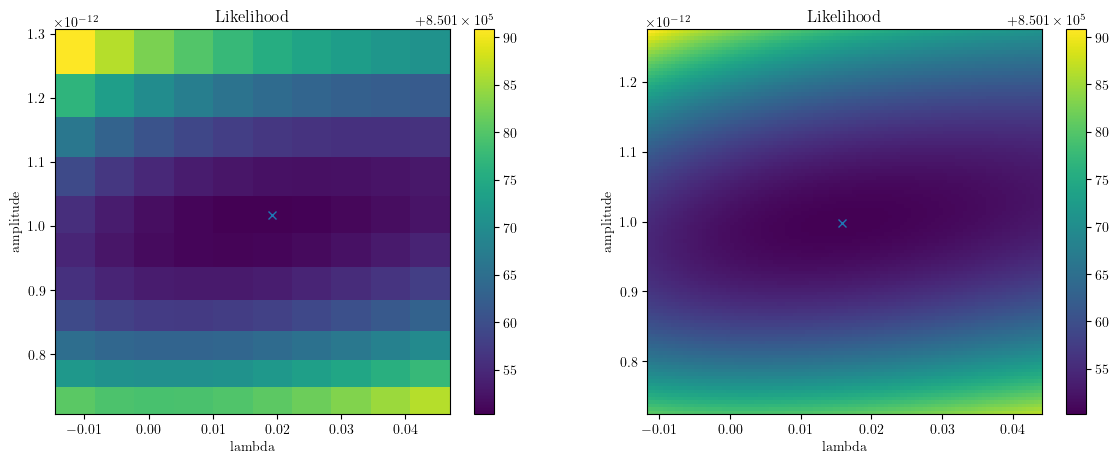

In [18]:
fig, (ax1, ax) = plt.subplots(1,2, figsize = (14,5))


im =ax1.pcolormesh(indexy__, amplix__, contour['stat_scan'])
dddd = np.array(contour['stat_scan'])
ampli_best = amplix__[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best, ampli_best, 'x')
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel("lambda",)
ax1.set_title(f"Likelihood")


im =ax.pcolormesh(indexy__new, amplix__new, data_contour)
dddd = np.array(data_contour)
ampli_best = amplix__new[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__new[np.where(dddd == dddd.min())[1][0]]
print("min lambda:", index_best)
print("min amplitude:", ampli_best)

ax.plot(index_best, ampli_best, 'x')
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel("lambda",)
ax.set_title(f"Likelihood")

9.447920822327332e-13 1.0549306418458718e-12 0.0016608960258728007 0.0340635240827038 9.998613620393025e-13 0.016186212051348764


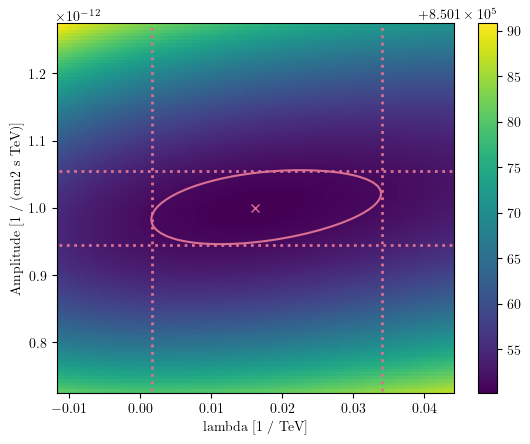

In [19]:
threshold_contour = 1

ampli_min_asimov,  ampli_max_asimov, index_min_asimov, index_max_asimov,  ampli_best_asimov, index_best_asimov = compute_errors(
    data_contour, indexy__new, amplix__new,  threshold_contour, find_min = True)
print(ampli_min_asimov,  ampli_max_asimov, index_min_asimov, index_max_asimov,  ampli_best_asimov, index_best_asimov )
CS= plot_L(data_contour, indexy__new, amplix__new,  threshold_contour,
      find_min = True, color = colors[2])

dat= CS.allsegs[0][0]

## Asimov Likelihood N

In [20]:
%%time
if computing:
    x_N = dataset_asimov_N.models.parameters['amplitude']
    y_N = dataset_asimov_N.models.parameters['lambda_']

    x_N.scan_values = x.scan_values
    y_N.scan_values = y.scan_values

    contour_N = fit_cor.stat_surface([dataset_asimov_N], x_N, y_N, reoptimize=True ) 


    contour_write = dict()
    for k in contour_N.keys():
        print(k)
        if k != 'fit_results':
            contour_write[k]  = contour_N[k].tolist()
            
    with open('data/7c_contour_N_amlp_cutoff.yml' , 'w') as outfile:
        yaml.dump(contour_write, outfile, default_flow_style=False)
        
else:
    with open('data/7c_contour_N_amlp_cutoff.yml', 'r') as stream:
        contour_N=yaml.safe_load(stream)
        
#print(contour_N)
source_N = list(contour_N.keys())[0][:-24]

amplix___N = contour_N[f'{source_N}.spectral.amplitude_scan']
indexy___N = contour_N[f'{source_N}.spectral.lambda__scan']
amplix__new_N =  np.linspace(amplix___N[0], amplix___N[-1],N_new)
indexy__new_N =  np.linspace(indexy___N[0], indexy___N[-1],N_new_y)    
        

f = interp2d(x = indexy___N, y= amplix___N, z = contour_N['stat_scan'], kind='cubic',fill_value = None, bounds_error = False )
data_contour_N = f(indexy__new_N, amplix__new_N)

npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npre

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npre

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npre

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npre

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npre

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npre

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npre

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npre

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npre

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npre

min lambda_: 0.015906879050858844
min amplitude: 9.973582129571858e-13


Text(0.5, 1.0, 'Likelihood')

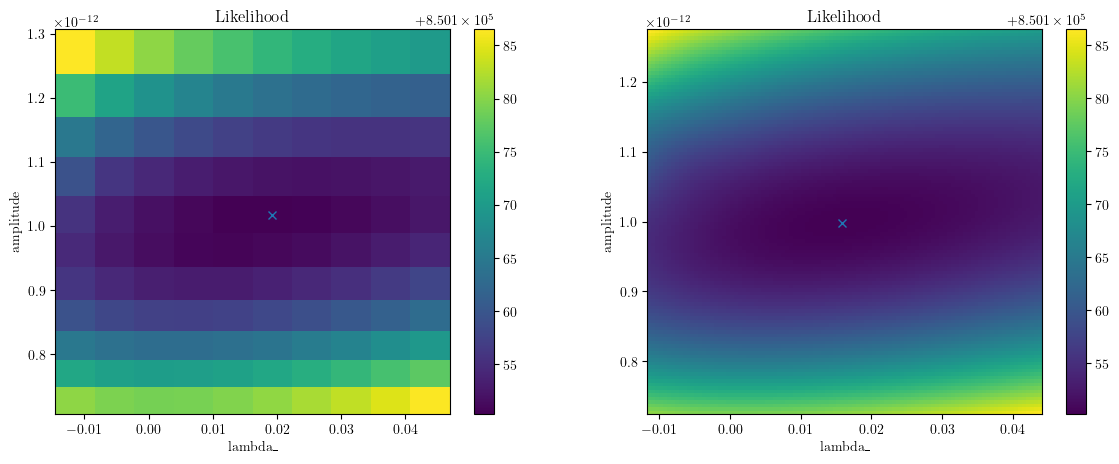

In [21]:
fig, (ax1, ax) = plt.subplots(1,2, figsize = (14,5))

im =ax1.pcolormesh(indexy___N, amplix___N, contour_N['stat_scan'])
dddd = np.array(contour_N['stat_scan'])
ampli_best_N = amplix___N[np.where(dddd == dddd.min())[0][0]]
index_best_N = indexy___N[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best_N, ampli_best_N, 'x')
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel("lambda_",)
ax1.set_title(f"Likelihood")


im =ax.pcolormesh(indexy__new_N, amplix__new_N, data_contour_N)
dddd = np.array(data_contour_N)
ampli_best_N = amplix__new_N[np.where(dddd == dddd.min())[0][0]]
index_best_N = indexy__new_N[np.where(dddd == dddd.min())[1][0]]
print("min lambda_:", index_best_N)
print("min amplitude:", ampli_best_N)

ax.plot(index_best_N, ampli_best_N, 'x')
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel("lambda_",)
ax.set_title(f"Likelihood")

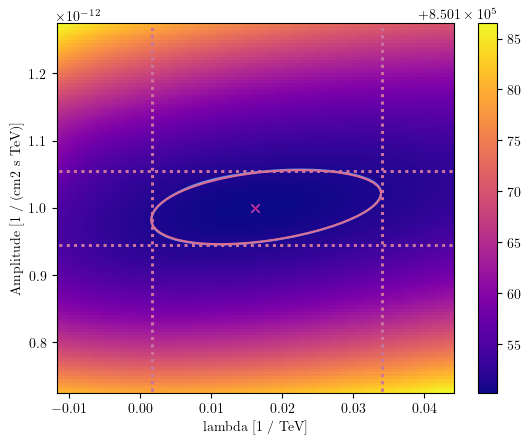

In [22]:
ampli_min_asimov_N,  ampli_max_asimov_N, index_min_asimov_N, index_max_asimov_N, ampli_best_asimov_N, index_best_asimov_N = compute_errors(
    data_contour_N, indexy__new_N, amplix__new_N,  threshold_contour, find_min = True)
cmap = 'plasma'
CS_N= plot_L(data_contour_N, indexy__new_N, amplix__new_N,  threshold_contour,
      find_min = True, color = colors[3], cmap = cmap)
ax = plt.gca()
plot_errors(ax,  indexy__new, amplix__new, 
    ampli_min_asimov,  ampli_max_asimov, index_min_asimov, index_max_asimov,  ampli_best_asimov, index_best_asimov,
           colors[2])

dat_N = CS_N.allsegs[0][0]
ax.clabel(CS, CS.levels, inline=True, fmt='$1$', fontsize=12)

plt.plot(dat[:,0],dat[:,1], color = colors[2], )

plt.plot(index_best_asimov_N, ampli_best_asimov_N, 'x', color = colors[3])
plt.plot(index_best_asimov, ampli_best_asimov, 'x', color = colors[0])
fig = plt.gcf()
if savefig:
    fig.savefig(f"plots/7c_L_contour_ampl_lambda." + picformat)   
    

## Compute fraction of within

In [23]:
def fraction_within(lower_lim, upper_lim, data):
    is_within = []
    for d in data:
        larger = np.all(d[0] >= lower_lim )
        smaller = np.all(d[0] <= upper_lim)
        is_within.append(larger and smaller)
        
    return (np.count_nonzero(is_within) / len(data))
    

In [24]:
# std best fit, nui best fit, ... 
within_norm = [fraction_within(valuies_asimov[0][0] - valuies_asimov[0][1],
                               valuies_asimov[0][0] +  valuies_asimov[0][1],
                               norms
                              ),
               fraction_within(valuies_asimov_N[0][0] - valuies_asimov_N[0][1],
                               valuies_asimov_N[0][0] + valuies_asimov_N[0][1],
                               norms
                              ),
               0., 0.,
              ]

within_amplitude = [fraction_within(valuies_asimov[1][0] - valuies_asimov[1][1],
                               valuies_asimov[1][0] +  valuies_asimov[1][1],
                               amplitudes
                              ),
               fraction_within(valuies_asimov_N[1][0] - valuies_asimov_N[1][1],
                               valuies_asimov_N[1][0] + valuies_asimov_N[1][1],
                               amplitudes
                              ),
               fraction_within(ampli_min_asimov,
                               ampli_max_asimov,
                               amplitudes
                              ),
                fraction_within(ampli_min_asimov_N,
                               ampli_max_asimov_N,
                               amplitudes
                              ),
                ]

within_index = [fraction_within(valuies_asimov[2][0] - valuies_asimov[2][1],
                               valuies_asimov[2][0] +  valuies_asimov[2][1],
                               indices
                              ),
               fraction_within(valuies_asimov_N[2][0] - valuies_asimov_N[2][1],
                               valuies_asimov_N[2][0] + valuies_asimov_N[2][1],
                               indices
                              ),
                fraction_within(index_min_asimov,
                               index_max_asimov,
                               indices
                              ),
                fraction_within(index_min_asimov_N,
                               index_max_asimov_N,
                               indices
                              ),]

withins = [within_norm, 
          within_amplitude,
          within_index]
print(withins)

NameError: name 'norms' is not defined

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (4,7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]
legends = ["Nuisance",'Standard',   ]


axs[2].errorbar(x = np.mean(indices[:,0]) ,y = 50, xerr = np.std(indices[:,0]), fmt='o', 
                color = 'navy', label = "$\mu$, $\sigma$")
axs[1].errorbar(x = np.mean(amplitudes[:,0]) ,y = 50, xerr = np.std(amplitudes[:,0]), fmt='o',
               color = 'navy', label = "$\mu$, $\sigma$")
axs[0].errorbar(x = np.mean(norms[:,0]) ,y = 50, xerr = np.std(norms[:,0]), fmt='o',
               color = 'navy', label = "$\mu$, $\sigma$")

for i, v in enumerate(valuies):
    print(i, xlabels[i])
    axs[i].hist(v[1:,0], color ='darkgreen', alpha = 0.8)
    ylim = axs[i].get_ylim()
    delta_ylim = 5
    
    axs[i].vlines(valuies_asimov_N[i][0], ylim[0], ylim[1]+ delta_ylim, color = colors[1], 
                 linestyle= 'dashed', )
    axs[i].fill_between([valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
                         valuies_asimov_N[i][0] + valuies_asimov_N[i][1]]
                        , ylim[0], ylim[1]+ delta_ylim,
                       alpha = 0.6, color = colors[3], 
                        label = legends[0] + f' \n({withins[i][1]*100 :.3}\%)')
    axs[i].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color = colors[0])
    axs[i].fill_between([valuies_asimov[i][0] - valuies_asimov[i][1],
                         valuies_asimov[i][0] + valuies_asimov[i][1]]
                        , ylim[0], ylim[1],
                       alpha = 0.9 , color = colors[2], 
                        label = legends[1] +  f' \n({withins[i][0]*100 :.3}\%)'  )
    
    axs[i].set_xlabel(xlabels[i])  
    
    
    x = axs[i].get_xlim()
    deltax = np.max([ valuies_asimov[i][0] - x[0] , x[1] - valuies_asimov[i][0] ])
    axs[i].set_xlim(valuies_asimov[i][0] -deltax, 
                    valuies_asimov[i][0] + deltax)
    
ylim = axs[1].get_ylim()
delta_ylim = 9  
axs[1].vlines(ampli_min_asimov_N, ylim[0], ylim[1]+delta_ylim, color = colors[1],  linestyle = 'dashed') 
axs[1].vlines(ampli_max_asimov_N, ylim[0], ylim[1]+delta_ylim, color = colors[1],  linestyle = 'dashed',
             label=f'({withins[1][3]*100:.3} \%)')    
axs[1].vlines(ampli_best_asimov_N, ylim[0], ylim[1]+delta_ylim, color = colors[1],
              linestyle = 'dotted')

delta_ylim = 2
axs[1].vlines(ampli_min_asimov, ylim[0], ylim[1]+delta_ylim, color = colors[0],  linestyle = 'dashed') 
axs[1].vlines(ampli_max_asimov, ylim[0], ylim[1]+delta_ylim, color = colors[0],  linestyle = 'dashed',
             label=f'({withins[1][2]*100:.3} \%)')    
axs[1].vlines(ampli_best_asimov, ylim[0], ylim[1]+delta_ylim, color = colors[0],
              linestyle = 'dotted')

ylim = axs[2].get_ylim()
delta_ylim = 9

axs[2].vlines(index_min_asimov_N, ylim[0], ylim[1]+delta_ylim, color = colors[1], linestyle = 'dashed') 
axs[2].vlines(index_max_asimov_N, ylim[0], ylim[1]+delta_ylim, color = colors[1], linestyle = 'dashed',
             label=f'({withins[2][3]*100:.3} \%)')   
axs[2].vlines(index_best_asimov_N, ylim[0], ylim[1]+delta_ylim, color = colors[1],
              linestyle = 'dotted')
delta_ylim = 2
axs[2].vlines(index_min_asimov, ylim[0], ylim[1]+delta_ylim, color = colors[0], linestyle = 'dashed') 
axs[2].vlines(index_max_asimov, ylim[0], ylim[1]+delta_ylim, color = colors[0], linestyle = 'dashed',
             label=f'({withins[2][2]*100:.3} \%)') 
axs[2].vlines(index_best_asimov, ylim[0], ylim[1]+delta_ylim, color = colors[0],
              linestyle = 'dotted')
plt.tight_layout()
for a in axs:
    a.legend(title="1$\sigma$ eror",loc='center left', bbox_to_anchor=(1, 0.5))



## 2D Histograms Poission

In [ ]:
N_bins = N_new + 1
N_bins_y = N_new_y + 1

amplitude_bin = np.linspace(amplix__new_N[0], amplix__new_N[-1], N_bins )
index_bin = np.linspace(indexy__new_N[0], indexy__new_N[-1], N_bins_y )

amplitudes_data = valuies[1][:,0]
indices_data = valuies[2][:,0]
data_N_new, (abins, ibins) = np.histogramdd((amplitudes_data, indices_data), (amplitude_bin, index_bin))

fig, ax = plt.subplots()
im =ax.pcolormesh(ibins, 
           abins,
           data_N_new)

fig.colorbar(im, ax=ax)
ax.plot(index_best_N, ampli_best_N, 'x', color = 'green')
ax.plot(index_best, ampli_best, 'x', color = 'red')

ax.set_ylabel("Amplitudes")
ax.set_xlabel("Indices")
plt.plot(dat[:,0],dat[:,1], color = 'red')
plt.plot(dat_N[:,0],dat_N[:,1], color = 'green')

In [ ]:
def compute_inside(Ls_new, x_new,
               y_new, threshold,  find_min = False,  delta=1
                 ):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    outside = Ls_new* (Ls_new < offset)
    inside = Ls_new* (Ls_new >= offset)

    return outside
    

In [ ]:
threshold_contour = 1
outside_N = compute_inside(
    data_contour_N, amplix__new_N,
           indexy__new_N,  threshold_contour,  find_min = True, delta =1 )

outside = compute_inside(
    data_contour, amplix__new_N,
           indexy__new_N, threshold_contour,  find_min = True, delta =1 )

outside_N = outside_N <-1.0
outside = outside <-1.0



In [ ]:
masked_N =  data_N_new * outside_N
masked =  data_N_new * outside

fig, (ax, ax2) = plt.subplots(1,2, figsize = (11,4))
im =ax.pcolormesh(indexy__new_N,
           amplix__new_N, masked)

fig.colorbar(im, ax=ax)
im =ax2.pcolormesh(indexy__new_N,
           amplix__new_N, masked_N)

fig.colorbar(im, ax=ax2)
for a in [ax, ax2]:
    a.set_ylabel("amplitude")
    a.set_xlabel("index",)
    a.plot(dat[:,0],dat[:,1], color = 'red')
    a.plot(dat_N[:,0],dat_N[:,1], color = 'green')

fraction_within_2d_N = np.sum(masked_N) /  np.sum(data_N_new)
fraction_within_2d = np.sum(masked) /  np.sum(data_N_new)

ax2.set_title(f"Likelihood Nuisance: {fraction_within_2d_N:.3}")
ax.set_title(f"Likelihood {fraction_within_2d:.3}")

## Special Plot

In [ ]:



axs[0].errorbar(x = np.mean(norms[:,0]) ,y = 50, xerr = np.std(norms[:,0]), fmt='o',
               color = 'navy', label = "$\mu$, $\sigma$")

In [ ]:
color_rnd = 'sandybrown'
color_rnd_err = 'darkorange'
alpha_nui = 0.7
alpha_st = 0.5
legends = ['With Sys.:\n', 'Without Sys.:\n']

ampli_min_asimov_N,  ampli_max_asimov_N, index_min_asimov_N, index_max_asimov_N, ampli_best_asimov_N, index_best_asimov_N = compute_errors(
    data_contour_N, indexy__new_N, amplix__new_N,  threshold_contour, find_min = True)

fig, axs = plt.subplots(2,2, gridspec_kw={'height_ratios': [3, 5], 'width_ratios':[5,3]},
                        figsize =(5.,5.)
                       )
axs_L = axs[1][0]
axs_i = axs[0][0]
axs_a = axs[1][1]
axs[0, -1].axis('off')

cmap = 'plasma'

CS_N= plot_L(data_contour_N, indexy__new_N, amplix__new_N,  threshold_contour,
      find_min = True, color = colors[3],ax = axs_L, fig = fig, cbar = False, cmap = cmap)

dat_N = CS_N.allsegs[0][0]
axs_L.plot(dat[:,0],dat[:,1], color = colors[2])
axs_L.plot(index_best_asimov_N, ampli_best_asimov_N, 'x', color = colors[3])
axs_L.plot(index_best_asimov, ampli_best_asimov, 'x', color = colors[2])

plot_errors(axs_L,  indexy__new, amplix__new, 
    ampli_min_asimov,  ampli_max_asimov, index_min_asimov, index_max_asimov,  ampli_best_asimov, index_best_asimov,
           colors[2])

xlims = [None,amplix__new_N, indexy__new_N ]

## ampli
a = axs_a
i = 1
a.hist(valuies[i][1:,0], color =color_rnd, alpha = 0.8, bins= np.linspace(xlims[i][0], xlims[i][-1], 10),
      orientation='horizontal' )
ylim = a.get_xlim()
delta_ylim = 5
a.hlines(valuies_asimov_N[i][0], ylim[0], ylim[1]+ delta_ylim, color = colors[1], 
             linestyle= 'dashed', )
a.fill_betweenx([valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
                     valuies_asimov_N[i][0] + valuies_asimov_N[i][1]]
                    , ylim[0], ylim[1]+ delta_ylim,
                   alpha = alpha_nui, color = colors[3], 
                    label = legends[0] + f'{withins[i][1]*100 :.3}\%')
a.hlines(valuies_asimov[i][0], ylim[0], ylim[1], color = colors[0])
a.fill_betweenx([valuies_asimov[i][0] - valuies_asimov[i][1],
                     valuies_asimov[i][0] + valuies_asimov[i][1]]
                    , ylim[0], ylim[1],
                   alpha = alpha_st , color = colors[2], 
                    label = legends[1] +  f'{withins[i][0]*100 :.3}\%'  )
a.set_xlabel('')
a.set_ylim(axs_L.get_ylim()[0], axs_L.get_ylim()[1])
yy = a.get_xlim()[1]
print(f"amplitudes: {np.mean(amplitudes[:,0])} pm {np.std(amplitudes[:,0])}") 
a.errorbar(x = yy/3 ,y = np.mean(amplitudes[:,0]), yerr = np.std(amplitudes[:,0]), fmt='o',
              color = color_rnd_err, label = "")

a.set_yticklabels([])
a.set_yticks([])
a.legend()
## index
a = axs_i
i =2
a.hist(valuies[i][1:,0], color =color_rnd, alpha = 0.8, bins= np.linspace(xlims[i][0], xlims[i][-1], 10),
       )
ylim = a.get_ylim()
delta_ylim = 5
a.vlines(valuies_asimov_N[i][0], ylim[0], ylim[1]+ delta_ylim, color = colors[1], 
             linestyle= 'dashed', )
a.fill_between([valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
                     valuies_asimov_N[i][0] + valuies_asimov_N[i][1]]
                    , ylim[0], ylim[1]+ delta_ylim,
                   alpha =alpha_nui, color = colors[3], 
                    label = legends[0] + f'{withins[i][1]*100 :.3}\%')
a.vlines(valuies_asimov[i][0], ylim[0], ylim[1], color = colors[0])
a.fill_between([valuies_asimov[i][0] - valuies_asimov[i][1],
                     valuies_asimov[i][0] + valuies_asimov[i][1]]
                    , ylim[0], ylim[1],
                   alpha = alpha_st, color = colors[2], 
                    label = legends[1] +  f'{withins[i][0]*100 :.3}\%'  )
a.set_xlabel(xlabels[i])  
yy = a.get_ylim()[1]
print(f"index: {np.mean(indices[:,0])} pm {np.std(indices[:,0])}") 
a.errorbar(x = np.mean(indices[:,0]) ,y = yy/3, xerr = np.std(indices[:,0]), fmt='o', 
                color = color_rnd_err, label = "")
a.set_xlim(axs_L.get_xlim()[0], axs_L.get_xlim()[1])
a.set_xlabel('')
a.set_xticklabels([])
a.set_xticks([])




plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.9,
                    wspace=0.08,
                    hspace=0.08)
a.legend( )#bbox_to_anchor=(1, 0.7))
#plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7c_L_contour_{shift}_dist." + picformat)   
    fig.savefig(f"plots/7c_L_contour_{shift}_dist." + "png")   
print(N)


In [ ]:
fig, axs = plt.subplots(3,1, figsize = (4,7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]
legends = ["Nuisance",'Standard',   ]

for i, v in enumerate(valuies):
    print(i, xlabels[i])
    axs[i].hist(v[1:,0], color ='steelblue', alpha = 0.8)
    ylim = axs[i].get_ylim()
    delta_ylim = 5
    
    axs[i].vlines(valuies_asimov_N[i][0], ylim[0], ylim[1]+ delta_ylim, color = 'green', 
                 linestyle= 'dashed', )
    axs[i].fill_between([valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
                         valuies_asimov_N[i][0] + valuies_asimov_N[i][1]]
                        , ylim[0], ylim[1]+ delta_ylim,
                       alpha = 0.3, color = 'green', 
                        label = legends[0] + f' \n({withins[i][1]*100 :.3}\%)')
    axs[i].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color = 'red')
    axs[i].fill_between([valuies_asimov[i][0] - valuies_asimov[i][1],
                         valuies_asimov[i][0] + valuies_asimov[i][1]]
                        , ylim[0], ylim[1],
                       alpha = 0.4 , color = 'red', 
                        label = legends[1] +  f' \n({withins[i][0]*100 :.3}\%)'  )
    
    axs[i].set_xlabel(xlabels[i])  
    
    
    x = axs[i].get_xlim()
    deltax = np.max([ valuies_asimov[i][0] - x[0] , x[1] - valuies_asimov[i][0] ])
    axs[i].set_xlim(valuies_asimov[i][0] -deltax, 
                    valuies_asimov[i][0] + deltax)
    
ylim = axs[1].get_ylim()
delta_ylim = 9  
axs[1].vlines(ampli_min_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',  linestyle = 'dashed') 
axs[1].vlines(ampli_max_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',  linestyle = 'dashed',
             label=f'({withins[1][3]*100:.3} \%)')    
axs[1].vlines(ampli_best_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',
              linestyle = 'dotted')

delta_ylim = 2
axs[1].vlines(ampli_min_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',  linestyle = 'dashed') 
axs[1].vlines(ampli_max_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',  linestyle = 'dashed',
             label=f'({withins[1][2]*100:.3} \%)')    
axs[1].vlines(ampli_best_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',
              linestyle = 'dotted')

ylim = axs[2].get_ylim()
delta_ylim = 9

axs[2].vlines(index_min_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green', linestyle = 'dashed') 
axs[2].vlines(index_max_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green', linestyle = 'dashed',
             label=f'({withins[2][3]*100:.3} \%)')   
axs[2].vlines(index_best_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',
              linestyle = 'dotted')
delta_ylim = 2
axs[2].vlines(index_min_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red', linestyle = 'dashed') 
axs[2].vlines(index_max_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red', linestyle = 'dashed',
             label=f'({withins[2][2]*100:.3} \%)') 
axs[2].vlines(index_best_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',
              linestyle = 'dotted')
plt.tight_layout()
for a in axs:
    a.legend(title="1$\sigma$ eror",loc='center left', bbox_to_anchor=(1, 0.5))

